In [1]:
import ants
import nilearn
from nilearn import image
import os
import shutil
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nilearn.image import load_img
from nilearn.image import math_img
from nilearn.image import resample_to_img
from nipype.interfaces.ants import ApplyTransforms
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [4]:
#get dimensions of subjects to correct for resolution
def dim(path,string):
    nii = nib.load(path)
    header = nii.header
    voxel_dims = header.get_zooms()
    print(f'Voxel Dimensions of {string}: {voxel_dims}')
    
dim('/Volumes/Cingulate/Berlin51/Hotspots&Atlas/resampled/STN_lh.nii.gz','STN LH')
dim('/Volumes/Cingulate/Berlin51/Hotspots&Atlas/resampled/STN_rh.nii.gz','STN RH')
dim('/Volumes/Cingulate/Dystonia/Hotspots&Atlases/resampled/TOR-PSM_GPi_lh.nii.gz','GPi LH')
dim('/Volumes/Cingulate/Dystonia/Hotspots&Atlases/resampled/TOR-PSM_GPi_rh.nii.gz','GPi RH')

Voxel Dimensions of STN LH: (0.22000003, 0.22000003, 0.22000003)
Voxel Dimensions of STN RH: (0.22000003, 0.22000003, 0.22000003)
Voxel Dimensions of GPi LH: (0.22000003, 0.22000003, 0.22000003)
Voxel Dimensions of GPi RH: (0.22000003, 0.22000003, 0.22000003)


In [40]:
0.22000003* 0.22000003* 0.22000003

0.010648004356000596

In [ ]:
#converting MNI STN to each patient's native space
def mni2native_lh(directory):
    print(f'converting to native for {i}')
    at = ApplyTransforms()
    at.inputs.dimension = 3
    at.inputs.input_image = f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Hotspots&Atlas/pd_stn_n275_hotspot_lh.nii.gz'
    
    if os.path.exists(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-ax_T1w.nii'):
        at.inputs.reference_image = f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-ax_T1w.nii'
    elif os.path.exists(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-cor_T1w.nii'):
        at.inputs.reference_image = f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-cor_T1w.nii'
    elif os.path.exists(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-ax_T2w.nii'):
        at.inputs.reference_image = f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-ax_T2w.nii'
    elif os.path.exists(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-iso_T2w.nii'):
        at.inputs.reference_image = f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-iso_T2w.nii'
    else:
        at.inputs.reference_image = f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-sag_T1w.nii'
    
    at.inputs.output_image = f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/{i}_pd_stn_n275_hotspot_lh_native_output.nii'
    at.inputs.transforms = f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/normalization/transformations/{i}_from-MNI152NLin2009bAsym_to-anchorNative_desc-ants.nii.gz'
    at.inputs.invert_transform_flags = [False]
    at.run()

def mni2native_rh(directory):
    at = ApplyTransforms()
    at.inputs.dimension = 3
    at.inputs.input_image = f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Hotspots&Atlas/pd_stn_n275_hotspot_rh.nii.gz'
    
    if os.path.exists(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-ax_T1w.nii'):
        at.inputs.reference_image = f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-ax_T1w.nii'
    elif os.path.exists(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-cor_T1w.nii'):
        at.inputs.reference_image = f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-cor_T1w.nii'
    elif os.path.exists(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-ax_T2w.nii'):
        at.inputs.reference_image = f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-ax_T2w.nii'
    elif os.path.exists(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-iso_T2w.nii'):
        at.inputs.reference_image = f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-iso_T2w.nii'
    else:
        at.inputs.reference_image = f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/coregistration/anat/{i}_ses-preop_space-anchorNative_desc-preproc_acq-sag_T1w.nii'
    
    at.inputs.output_image = f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/{i}_pd_stn_n275_hotspot_rh_native_output.nii'
    at.inputs.transforms = f'/Volumes/Cingulate/Berlin51/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs/{i}/normalization/transformations/{i}_from-MNI152NLin2009bAsym_to-anchorNative_desc-ants.nii.gz'
    at.inputs.invert_transform_flags = [False]
    at.run()
    
directory = [i for i in os.listdir('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Data/derivatives/leaddbs') if i.startswith('sub')]

for i in directory:
    mni2native_lh(i)
    mni2native_rh(i)

In [19]:
#resampling and binarizing!
directory = [i for i in os.listdir('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip') if i.startswith('sub-BER051')]

stn_lh = load_img('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Hotspots&Atlas/STN_lh.nii.gz')
stn_rh = load_img('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Hotspots&Atlas/STN_rh.nii.gz')

#resample and binarize patients
def resample_binarize(sub,stn,path):
    re_sub = resample_to_img(sub,stn,interpolation='nearest')
    re_binarized_sub = math_img('img > 0.1', img=re_sub)
    nib.save(re_binarized_sub,path)

for i in directory:
    print(i)
    
    #load in native stns for resampling anchor
    stn_native_lh = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/{i}_STN_lh_native_output.nii')
    stn_native_rh = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/{i}_STN_rh_native_output.nii')
   
    #load in patients
    native_lh_sub = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/stimulations/native/gs_/{i}_sim-binary_model-simbio_hemi-L.nii')
    native_rh_sub = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/stimulations/native/gs_/{i}_sim-binary_model-simbio_hemi-R.nii')
    native2mni_lh_sub = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/stimulations/native2MNI/MNI152NLin2009bAsym/gs_/{i}_sim-binary_model-simbio_hemi-L.nii')
    native2mni_rh_sub = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/stimulations/native2MNI/MNI152NLin2009bAsym/gs_/{i}_sim-binary_model-simbio_hemi-R.nii')
    mni_lh_sub = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/stimulations/MNI152NLin2009bAsym/gs_/{i}_sim-binary_model-simbio_hemi-L.nii')
    mni_rh_sub = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/stimulations/MNI152NLin2009bAsym/gs_/{i}_sim-binary_model-simbio_hemi-R.nii')

    #call resample binarize
#     resample_binarize(native_lh_sub,stn_native_lh,f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/resampled/{i}_native_sim-binary_model-simbio_hemi-L.nii')
#     resample_binarize(native_rh_sub,stn_native_rh,f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/resampled/{i}_native_sim-binary_model-simbio_hemi-R.nii')
#     resample_binarize(native2mni_lh_sub,stn_lh,f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/resampled/{i}_native2MNI_sim-binary_model-simbio_hemi-L.nii')
#     resample_binarize(native2mni_rh_sub,stn_rh,f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/resampled/{i}_native2MNI_sim-binary_model-simbio_hemi-R.nii')
#     resample_binarize(mni_lh_sub,stn_lh,f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/resampled/{i}_MNI_sim-binary_model-simbio_hemi-L.nii')
#     resample_binarize(mni_rh_sub,stn_rh,f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/resampled/{i}_MNI_sim-binary_model-simbio_hemi-R.nii')

sub-BER051


In [34]:
#get volumes of binary and efield overlap
directory = [i for i in os.listdir('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip') if i.startswith('sub-BER')]

#make lists to store outputs in
native_stn_lh,native_stn_rh,native2mni_stn_lh,native2mni_stn_rh,mni_stn_lh,mni_stn_rh = [],[],[],[],[],[]
native_stn_motor_lh,native_stn_motor_rh,native2mni_stn_motor_lh,native2mni_stn_motor_rh,mni_stn_motor_lh,mni_stn_motor_rh = [],[],[],[],[],[]
native_pd_lh,native_pd_rh,native2mni_pd_lh,native2mni_pd_rh,mni_pd_lh,mni_pd_rh = [],[],[],[],[],[]

#load in mni hotspots
stn_lh = load_img('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Hotspots&Atlas/resampled/STN_lh.nii.gz')
stn_rh = load_img('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Hotspots&Atlas/resampled/STN_rh.nii.gz')
stn_motor_lh = load_img('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Hotspots&Atlas/resampled/STN_motor_lh.nii.gz')
stn_motor_rh = load_img('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Hotspots&Atlas/resampled/STN_motor_rh.nii.gz')
pd_lh = load_img('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Hotspots&Atlas/resampled/pd_stn_n275_hotspot_lh.nii.gz')
pd_rh = load_img('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Hotspots&Atlas/resampled/pd_stn_n275_hotspot_rh.nii.gz')

def get_efield_overlap(stn,sub,volume_list):
    mask = math_img('img1*img2',img1=stn,img2=sub)
    mask = mask.get_fdata()
    no0_mask = mask[mask!=0]
    volume = np.mean(no0_mask)
    volume_list.append(volume)
    
def get_binary_overlap(stn,sub,volume_list):
    mask = math_img('img1*img2',img1=stn,img2=sub)
    mask = mask.get_fdata()
    volume = np.sum(mask)
    volume_list.append(volume)

#loop over to get volume
for i in directory:
    print(i)
    #load in all subjects: native, native2mni, and mni
    sub_native_lh = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-L.nii')
    sub_native_rh = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native_sim-binary_model-ossdbs_hemi-R.nii')
    sub_native2mni_lh = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native2MNI_sim-binary_model-ossdbs_hemi-L.nii')
    sub_native2mni_rh = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_native2MNI_sim-binary_model-ossdbs_hemi-R.nii')
    sub_mni_lh = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_MNI_sim-binary_model-ossdbs_hemi-L.nii')
    sub_mni_rh = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/OSS-DBS/{i}/resampled/{i}_MNI_sim-binary_model-ossdbs_hemi-R.nii')
    
    #load in native hotspots
    stn_nativespace_lh = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/{i}_STN_lh_native_output.nii')
    stn_nativespace_rh = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/{i}_STN_rh_native_output.nii')
    stn_motor_nativespace_lh = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/{i}_STN_motor_lh_native_output.nii')
    stn_motor_nativespace_rh = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/{i}_STN_motor_rh_native_output.nii')
    pd_nativespace_lh = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/{i}_pd_stn_n275_hotspot_lh_native_output.nii')
    pd_nativespace_rh = load_img(f'/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip/{i}/{i}_pd_stn_n275_hotspot_rh_native_output.nii')
    
    #call function to get the overlap!
    get_binary_overlap(stn_nativespace_lh,sub_native_lh,native_stn_lh)
    get_binary_overlap(stn_nativespace_rh,sub_native_rh,native_stn_rh)
    get_binary_overlap(stn_motor_nativespace_lh,sub_native_lh,native_stn_motor_lh)
    get_binary_overlap(stn_motor_nativespace_rh,sub_native_rh,native_stn_motor_rh)
    get_efield_overlap(pd_nativespace_lh,sub_native_lh,native_pd_lh)
    get_efield_overlap(pd_nativespace_rh,sub_native_rh,native_pd_rh)
    
    get_binary_overlap(stn_lh,sub_native2mni_lh,native2mni_stn_lh)
    get_binary_overlap(stn_rh,sub_native2mni_rh,native2mni_stn_rh)
    get_binary_overlap(stn_motor_lh,sub_native2mni_lh,native2mni_stn_motor_lh)
    get_binary_overlap(stn_motor_rh,sub_native2mni_rh,native2mni_stn_motor_rh)
    get_efield_overlap(pd_lh,sub_native2mni_lh,native2mni_pd_lh)
    get_efield_overlap(pd_rh,sub_native2mni_rh,native2mni_pd_rh)
    
    get_binary_overlap(stn_lh,sub_mni_lh,mni_stn_lh)
    get_binary_overlap(stn_rh,sub_mni_rh,mni_stn_rh)
    get_binary_overlap(stn_motor_lh,sub_mni_lh,mni_stn_motor_lh)
    get_binary_overlap(stn_motor_rh,sub_mni_rh,mni_stn_motor_rh)
    get_efield_overlap(pd_lh,sub_mni_lh,mni_pd_lh)
    get_efield_overlap(pd_rh,sub_mni_rh,mni_pd_rh)

sub-BER001
sub-BER002
sub-BER003
sub-BER004
sub-BER005
sub-BER006
sub-BER007
sub-BER008
sub-BER009
sub-BER010
sub-BER011
sub-BER012
sub-BER013
sub-BER014
sub-BER015
sub-BER016
sub-BER017
sub-BER018
sub-BER019
sub-BER020
sub-BER021
sub-BER022
sub-BER023
sub-BER024
sub-BER025
sub-BER026
sub-BER027
sub-BER028
sub-BER029
sub-BER030
sub-BER031
sub-BER032
sub-BER033
sub-BER034
sub-BER035
sub-BER036
sub-BER037
sub-BER038
sub-BER039
sub-BER040
sub-BER041
sub-BER042
sub-BER043
sub-BER044
sub-BER045
sub-BER046
sub-BER047
sub-BER048
sub-BER049
sub-BER050


In [35]:
#get bilateral values for each column, taking the average
native_stn_bi,native_stn_motor_bi,native_pd_bi = [],[],[]
native2mni_stn_bi,native2mni_stn_motor_bi,native2mni_pd_bi = [],[],[]
mni_stn_bi,mni_stn_motor_bi,mni_pd_bi = [],[],[]

native_stn_bi,native2mni_stn_bi,mni_stn_bi = [],[],[]

def efield_bilateral(list1,list2,averages_list):
    averages = [(x + y) / 2 for x, y in zip(list1, list2)]
    averages_list.extend(averages)
    
def binary_bilateral(list1,list2,sums_list):
    sums = [(x + y) for x, y in zip(list1, list2)]
    sums_list.extend(sums)

binary_bilateral(native_stn_lh,native_stn_rh,native_stn_bi)
binary_bilateral(native2mni_stn_lh,native2mni_stn_rh,native2mni_stn_bi)
binary_bilateral(mni_stn_lh,mni_stn_rh,mni_stn_bi)

binary_bilateral(native_stn_motor_lh,native_stn_motor_rh,native_stn_motor_bi)
binary_bilateral(native2mni_stn_motor_lh,native2mni_stn_motor_rh,native2mni_stn_motor_bi)
binary_bilateral(mni_stn_motor_lh,mni_stn_motor_rh,mni_stn_motor_bi)

efield_bilateral(native_pd_lh,native_pd_rh,native_pd_bi)
efield_bilateral(native2mni_pd_lh,native2mni_pd_rh,native2mni_pd_bi)
efield_bilateral(mni_pd_lh,mni_pd_rh,mni_pd_bi)

In [36]:
sub_ids = []
for i in directory:
    sub_ids.append(i)

In [37]:
df = pd.DataFrame(
    {'ID': sub_ids,
     'Native_STN_LH_Volume_Overlap': native_stn_lh,
     'Native_STN_RH_Volume_Overlap': native_stn_rh,
     'Native_STN_Bi_Volume_Overlap': native_stn_bi,
     'Native2MNI_STN_LH_Volume_Overlap': native2mni_stn_lh,
     'Native2MNI_STN_RH_Volume_Overlap': native2mni_stn_rh,
     'Native2MNI_STN_Bi_Volume_Overlap': native2mni_stn_bi,
     'MNI_STN_LH_Volume_Overlap': mni_stn_lh,
     'MNI_STN_RH_Volume_Overlap': mni_stn_rh,
     'MNI_STN_Bi_Volume_Overlap': mni_stn_bi,
     'Native_Motor_STN_LH_Volume_Overlap': native_stn_motor_lh,
     'Native_Motor_STN_RH_Volume_Overlap': native_stn_motor_rh,
     'Native_Motor_STN_Bi_Volume_Overlap': native_stn_motor_bi,
     'Native2MNI_Motor_STN_LH_Volume_Overlap': native2mni_stn_motor_lh,
     'Native2MNI_Motor_STN_RH_Volume_Overlap': native2mni_stn_motor_rh,
     'Native2MNI_Motor_STN_Bi_Volume_Overlap': native2mni_stn_motor_bi,
     'MNI_Motor_STN_LH_Volume_Overlap': mni_stn_motor_lh,
     'MNI_Motor_STN_RH_Volume_Overlap': mni_stn_motor_rh,
     'MNI_Motor_STN_Bi_Volume_Overlap': mni_stn_motor_bi,
     'Native_PD_STN_n275_Hotspot_LH_Volume_Overlap': native_pd_lh,
     'Native_PD_STN_n275_Hotspot_RH_Volume_Overlap': native_pd_rh,
     'Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap': native_pd_bi,
     'Native2MNI_PD_STN_n275_Hotspot_LH_Volume_Overlap': native2mni_pd_lh,
     'Native2MNI_PD_STN_n275_Hotspot_RH_Volume_Overlap': native2mni_pd_rh,
     'Native2MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap': native2mni_pd_bi,
     'MNI_PD_STN_n275_Hotspot_LH_Volume_Overlap': mni_pd_lh,
     'MNI_PD_STN_n275_Hotspot_RH_Volume_Overlap': mni_pd_rh,
     'MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap': mni_pd_bi
    })

df.to_csv('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/new_OSS-DBS_Berlin51_Overlap.csv')

# OSS-DBS Plots

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_45662/1649811216.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Column', y='Value', data=melted_df,palette='crest')


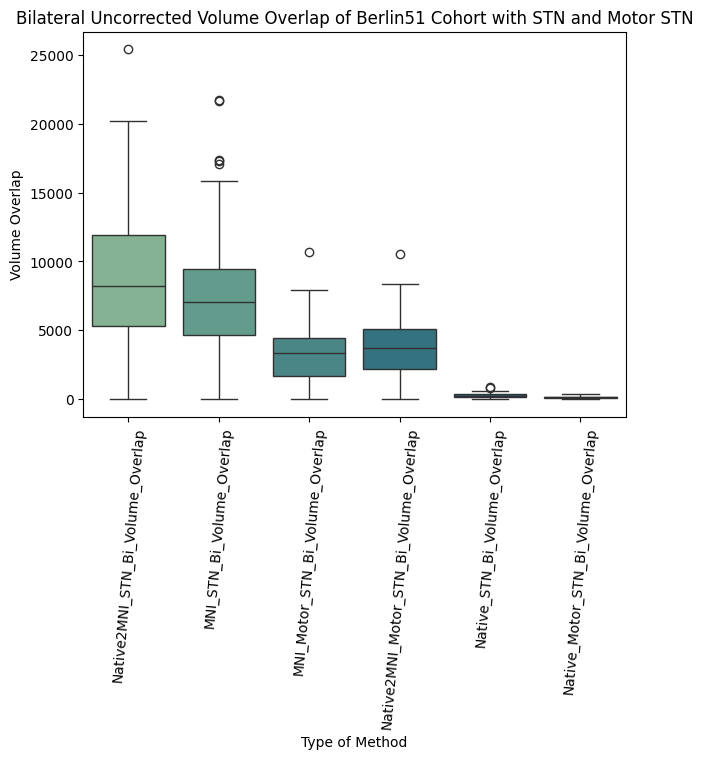

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_45662/1649811216.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Column', y='Value', data=melted_df,palette='crest')


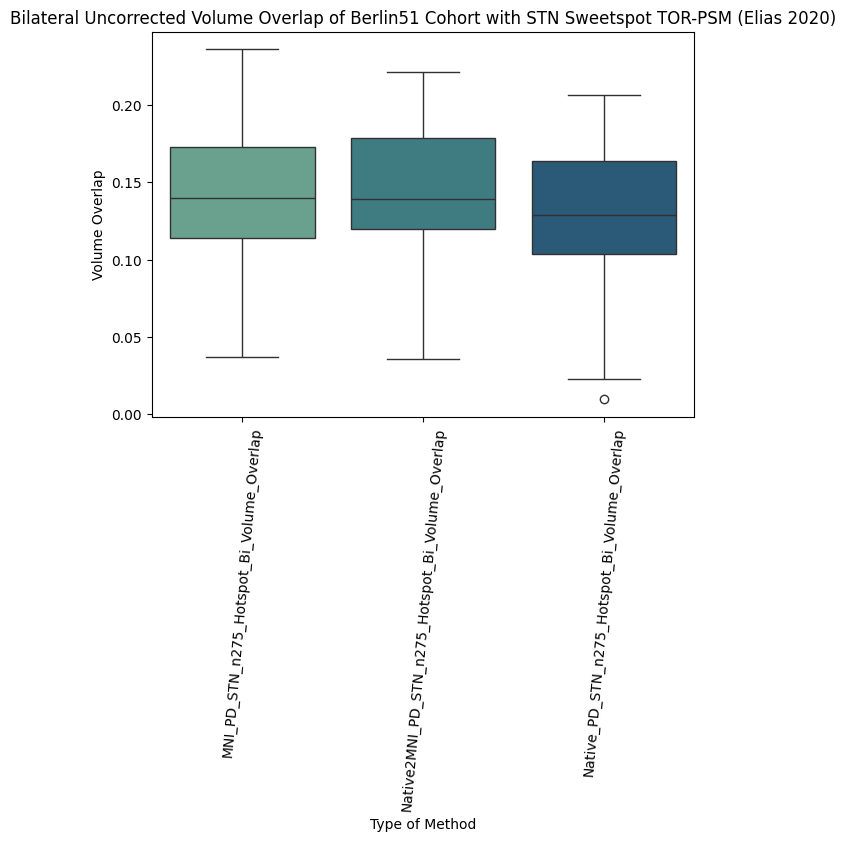

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_45662/1649811216.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Column', y='Value', data=melted_df,palette='crest')


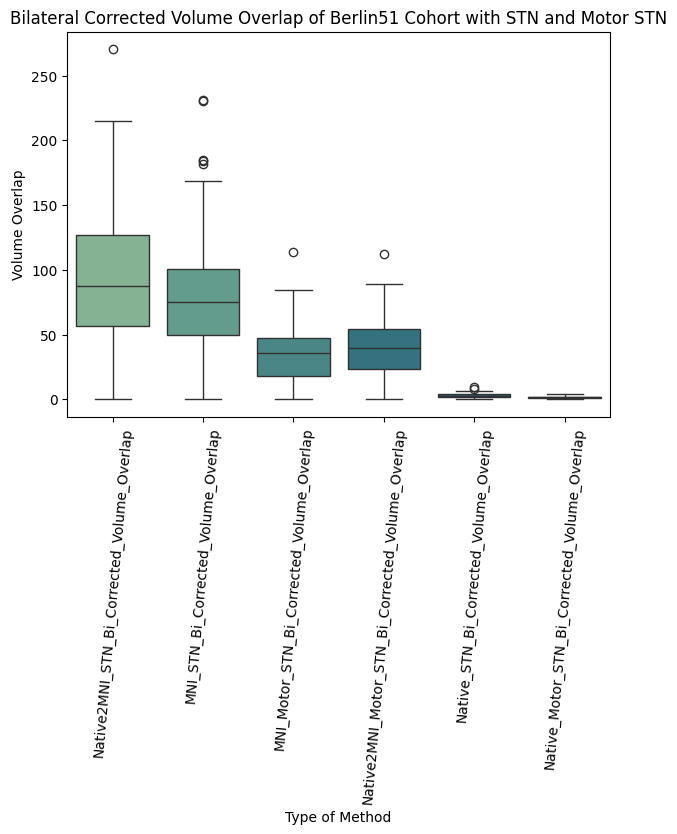

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_45662/1649811216.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Column', y='Value', data=melted_df,palette='crest')


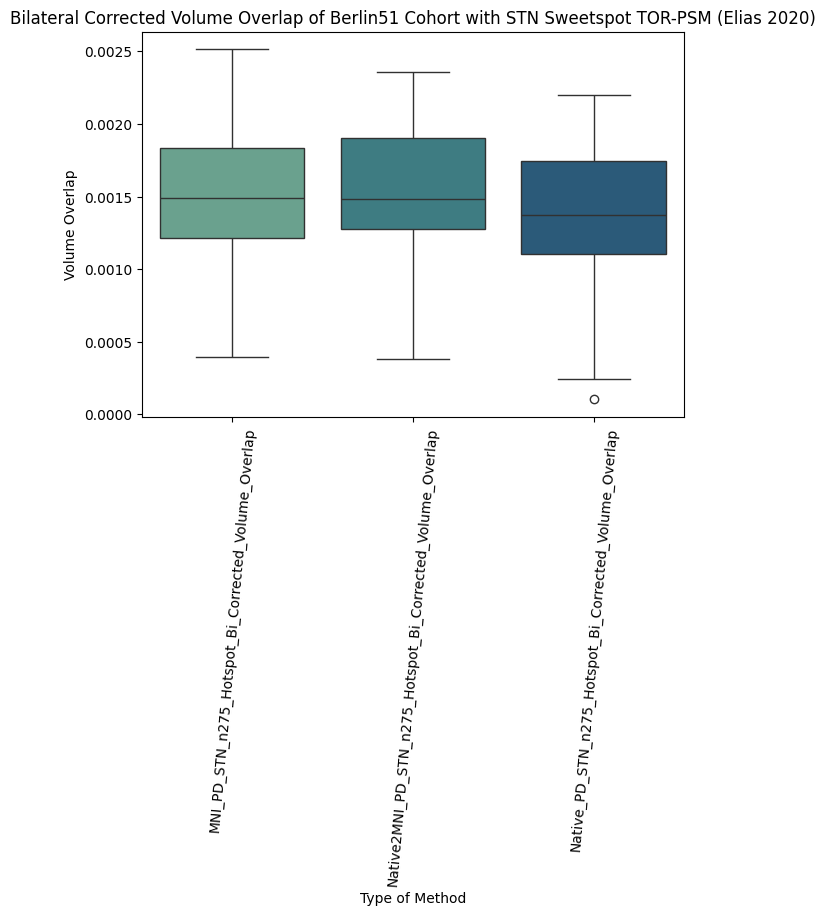

In [39]:
#plotting bilateral overlap with STN, motor STN, and STN hotspot
def plot_overlap(columns_to_include,title):
    df = pd.read_csv('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/OSS-DBS_Berlin51_Overlap.csv')
    selected_df = df[columns_to_include]
    melted_df = selected_df.melt(var_name='Column', value_name='Value')
    melted_df = melted_df.sort_values(by='Value', ascending=False)

    plt.figure(figsize=(7, 5))
    ax = sns.boxplot(x='Column', y='Value', data=melted_df,palette='crest')
    ax.set(xlabel = 'Type of Method',ylabel='Volume Overlap',title=title)
    ax.tick_params(axis='x', rotation=85)
    plt.show()
    
plot_overlap((['Native_STN_Bi_Volume_Overlap', 'Native2MNI_STN_Bi_Volume_Overlap','MNI_STN_Bi_Volume_Overlap','Native_Motor_STN_Bi_Volume_Overlap', 'Native2MNI_Motor_STN_Bi_Volume_Overlap','MNI_Motor_STN_Bi_Volume_Overlap']),'Bilateral Uncorrected Volume Overlap of Berlin51 Cohort with STN and Motor STN')
plot_overlap((['Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap','Native2MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap','MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap']),'Bilateral Uncorrected Volume Overlap of Berlin51 Cohort with STN Sweetspot TOR-PSM (Elias 2020)')
plot_overlap((['Native_STN_Bi_Corrected_Volume_Overlap', 'Native2MNI_STN_Bi_Corrected_Volume_Overlap','MNI_STN_Bi_Corrected_Volume_Overlap','Native_Motor_STN_Bi_Corrected_Volume_Overlap', 'Native2MNI_Motor_STN_Bi_Corrected_Volume_Overlap','MNI_Motor_STN_Bi_Corrected_Volume_Overlap']),'Bilateral Corrected Volume Overlap of Berlin51 Cohort with STN and Motor STN')
plot_overlap((['Native_PD_STN_n275_Hotspot_Bi_Corrected_Volume_Overlap','Native2MNI_PD_STN_n275_Hotspot_Bi_Corrected_Volume_Overlap','MNI_PD_STN_n275_Hotspot_Bi_Corrected_Volume_Overlap']),'Bilateral Corrected Volume Overlap of Berlin51 Cohort with STN Sweetspot TOR-PSM (Elias 2020)')

In [40]:
#get r and p values for overlaps
def r_p(vol_overlap_col):
    df = pd.read_csv('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/OSS-DBS_Berlin51_Overlap.csv')
    pearson_r, pearson_p = pearsonr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    spearman_r, spearman_p = spearmanr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    return pearson_r, pearson_p, spearman_r, spearman_p

native_stn_pearson_r,native_stn_pearson_p,native_stn_spearman_r,native_stn_spearman_p = r_p('Native_STN_Bi_Volume_Overlap')
native2mni_stn_pearson_r,native2mni_stn_pearson_p,native2mni_stn_spearman_r,native2mni_stn_spearman_p = r_p('Native2MNI_STN_Bi_Volume_Overlap')
mni_stn_pearson_r,mni_stn_pearson_p,mni_stn_spearman_r,mni_stn_spearman_p = r_p('MNI_STN_Bi_Volume_Overlap')

native_motor_stn_pearson_r,native_motor_stn_pearson_p,native_motor_stn_spearman_r,native_motor_stn_spearman_p = r_p('Native_Motor_STN_Bi_Volume_Overlap')
native2mni_motor_stn_pearson_r,native2mni_motor_stn_pearson_p,native2mni_motor_stn_spearman_r,native2mni_motor_stn_spearman_p = r_p('Native2MNI_Motor_STN_Bi_Volume_Overlap')
mni_motor_stn_pearson_r,mni_motor_stn_pearson_p,mni_motor_stn_spearman_r,mni_motor_stn_spearman_p = r_p('MNI_Motor_STN_Bi_Volume_Overlap')

native_pd_pearson_r,native_pd_pearson_p,native_pd_spearman_r,native_pd_spearman_p = r_p('Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap')
native2mni_pd_pearson_r,native2mni_pd_pearson_p,native2mni_pd_spearman_r,native2mni_pd_spearman_p = r_p('Native2MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap')
mni_pd_pearson_r,mni_pd_pearson_p,mni_pd_spearman_r,mni_pd_spearman_p = r_p('MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap')

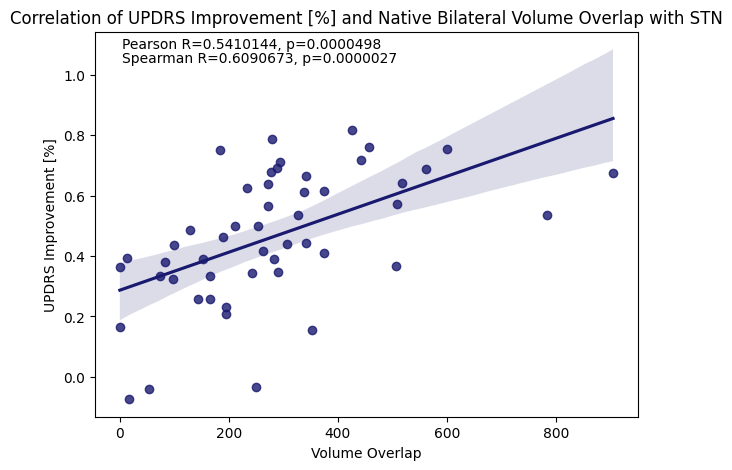

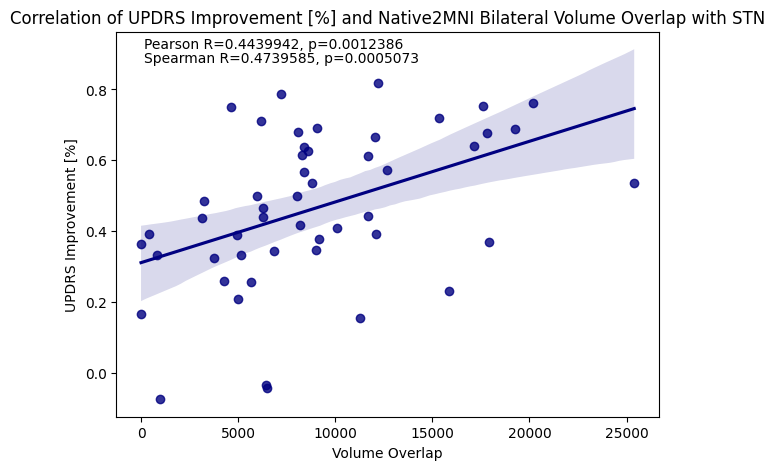

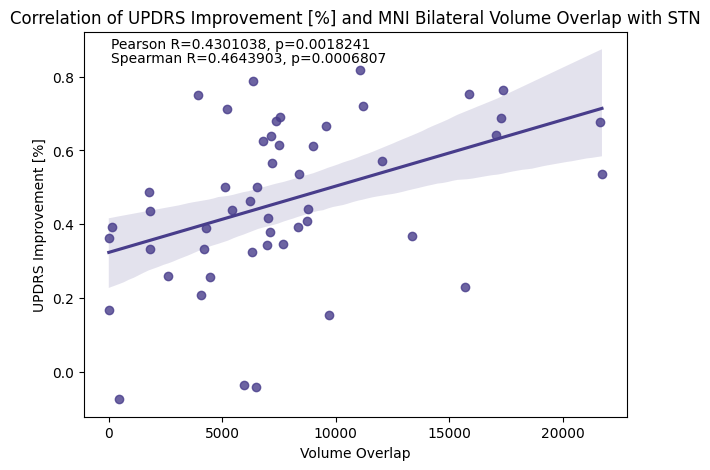

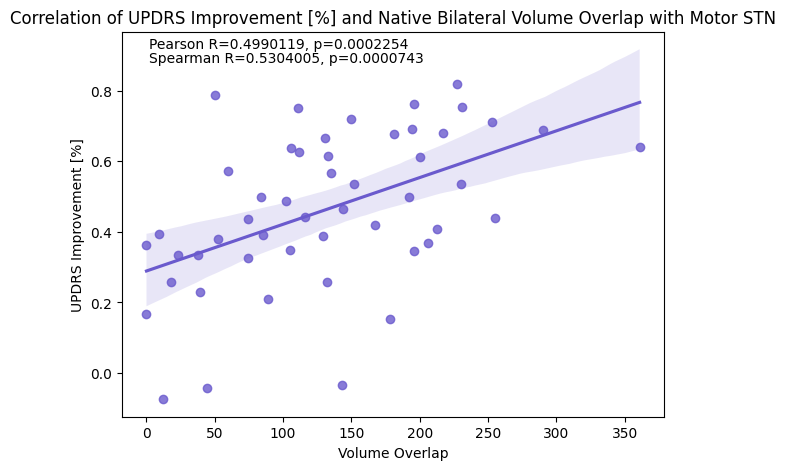

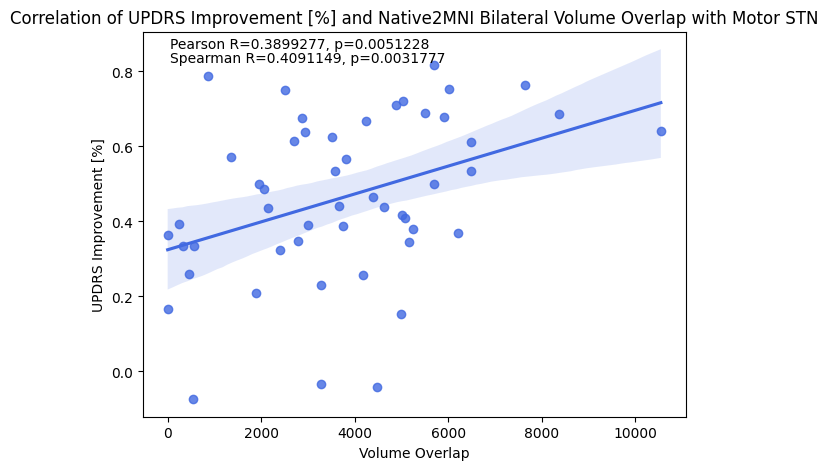

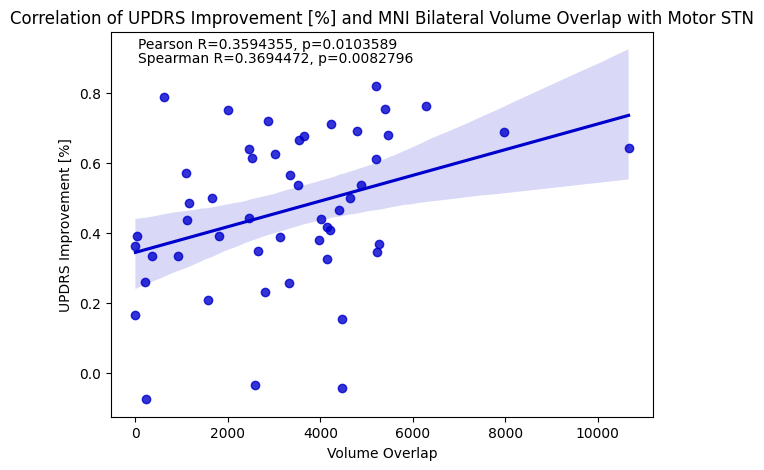

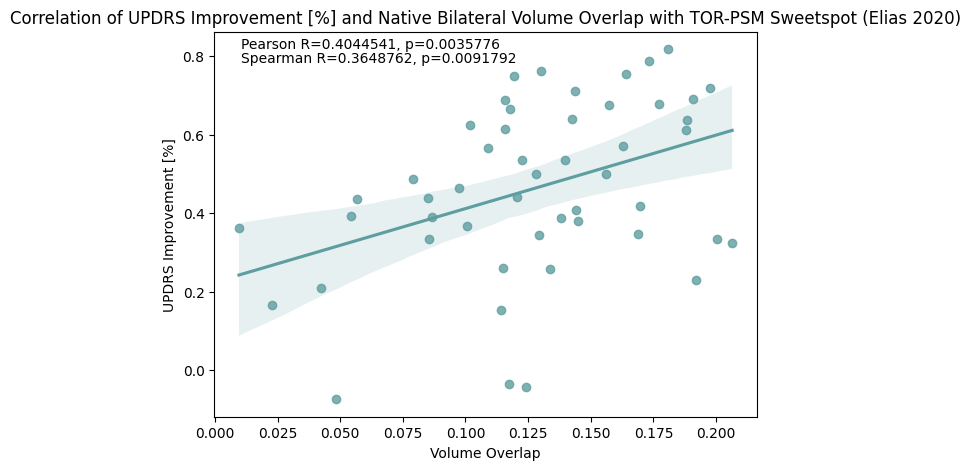

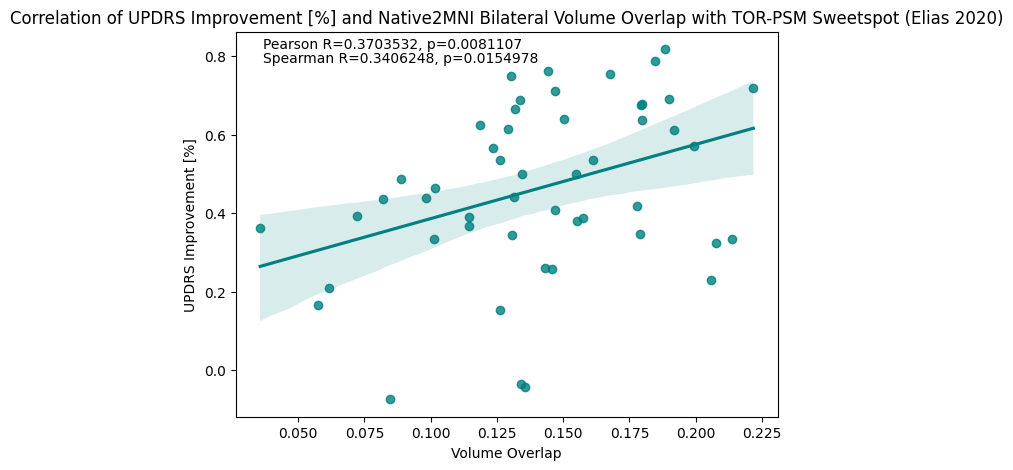

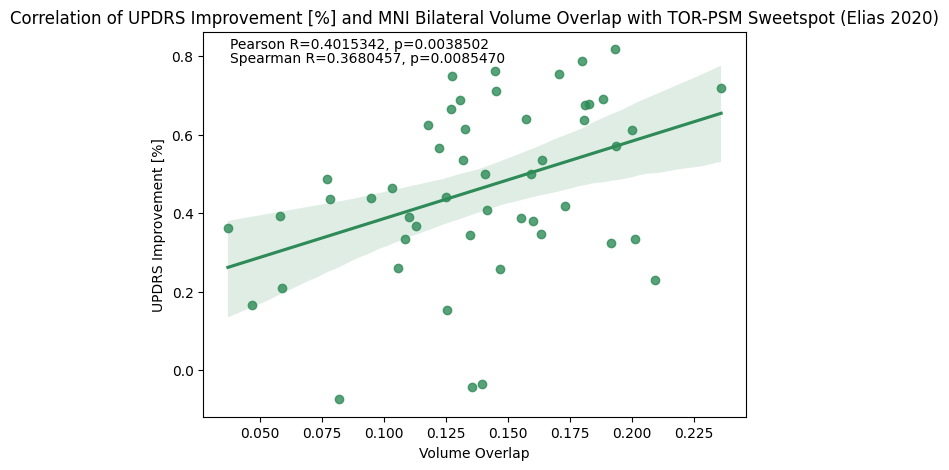

In [41]:
#correlation plots
def plot_analysis(x_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,path):
    plt.figure(figsize=(7, 5))
    ax = sns.regplot(x=x_data, y=df['UPDRS_Improvement_Perc'], color=color)
    plt.title(title)
    plt.xlabel('Volume Overlap')
    plt.ylabel('UPDRS Improvement [%]')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.savefig(path)
    plt.show()

df = pd.read_csv('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/OSS-DBS_Berlin51_Overlap.csv')
plot_analysis(df['Native_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native Bilateral Volume Overlap with STN',native_stn_pearson_r,native_stn_pearson_p,native_stn_spearman_r,native_stn_spearman_p,'midnightblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/OSS-DBS/Native Bilateral Volume Overlap with STN.png')
plot_analysis(df['Native2MNI_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native2MNI Bilateral Volume Overlap with STN',native2mni_stn_pearson_r,native2mni_stn_pearson_p,native2mni_stn_spearman_r,native2mni_stn_spearman_p,'navy','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/OSS-DBS/Native2MNI Bilateral Volume Overlap with STN.png')
plot_analysis(df['MNI_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and MNI Bilateral Volume Overlap with STN',mni_stn_pearson_r,mni_stn_pearson_p,mni_stn_spearman_r,mni_stn_spearman_p,'darkslateblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/OSS-DBS/MNI Bilateral Volume Overlap with STN.png')

plot_analysis(df['Native_Motor_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native Bilateral Volume Overlap with Motor STN',native_motor_stn_pearson_r,native_motor_stn_pearson_p,native_motor_stn_spearman_r,native_motor_stn_spearman_p,'slateblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/OSS-DBS/Native Bilateral Volume Overlap with Motor STN.png')
plot_analysis(df['Native2MNI_Motor_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native2MNI Bilateral Volume Overlap with Motor STN',native2mni_motor_stn_pearson_r,native2mni_motor_stn_pearson_p,native2mni_motor_stn_spearman_r,native2mni_motor_stn_spearman_p,'royalblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/OSS-DBS/Native2MNI Bilateral Volume Overlap with Motor STN.png')
plot_analysis(df['MNI_Motor_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and MNI Bilateral Volume Overlap with Motor STN',mni_motor_stn_pearson_r,mni_motor_stn_pearson_p,mni_motor_stn_spearman_r,mni_motor_stn_spearman_p,'mediumblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/OSS-DBS/MNI Bilateral Volume Overlap with Motor STN.png')

plot_analysis(df['Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020)',native_pd_pearson_r,native_pd_pearson_p,native_pd_spearman_r,native_pd_spearman_p,'cadetblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/OSS-DBS/Native Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020).png')
plot_analysis(df['Native2MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native2MNI Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020)',native2mni_pd_pearson_r,native2mni_pd_pearson_p,native2mni_pd_spearman_r,native2mni_pd_spearman_p,'teal','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/OSS-DBS/Native2MNI Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020).png')
plot_analysis(df['MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and MNI Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020)',mni_pd_pearson_r,mni_pd_pearson_p,mni_pd_spearman_r,mni_pd_spearman_p,'seagreen','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/OSS-DBS/MNI Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020).png')

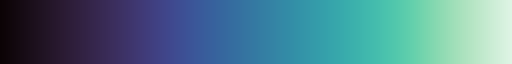

In [87]:
sns.color_palette("mako", as_cmap=True)

In [42]:
#correlation of different method overlaps (native vs mni)
#get r and p values
def r_p(native,mni):
    df = pd.read_csv('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/OSS-DBS_Berlin51_Overlap.csv')
    pearson_r, pearson_p = pearsonr(df[native],df[mni])
    spearman_r, spearman_p = spearmanr(df[native],df[mni])
    return pearson_r, pearson_p, spearman_r, spearman_p

stn_pearson_r,stn_pearson_p,stn_spearman_r,stn_spearman_p = r_p('Native_STN_Bi_Volume_Overlap','MNI_STN_Bi_Volume_Overlap')
motor_stn_pearson_r,motor_stn_pearson_p,motor_stn_spearman_r,motor_stn_spearman_p = r_p('Native_Motor_STN_Bi_Volume_Overlap','MNI_Motor_STN_Bi_Volume_Overlap')
pd_pearson_r,pd_pearson_p,pd_spearman_r,pd_spearman_p = r_p('Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap','MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap')

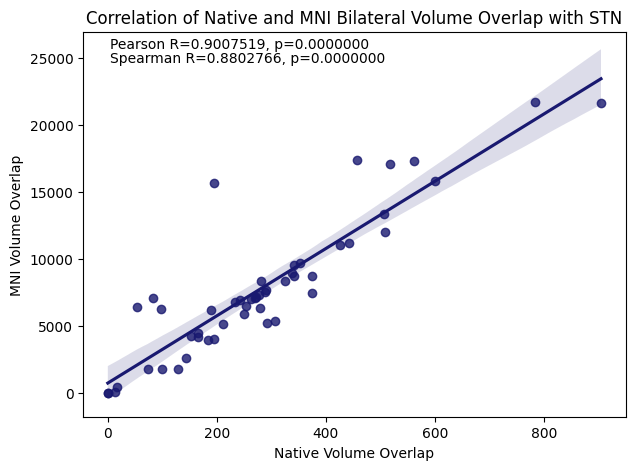

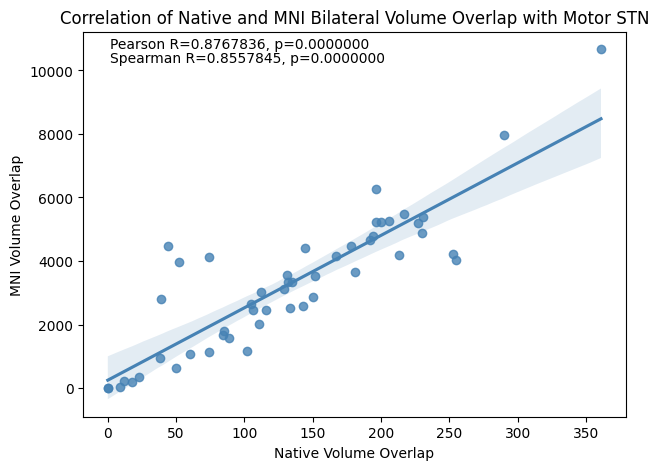

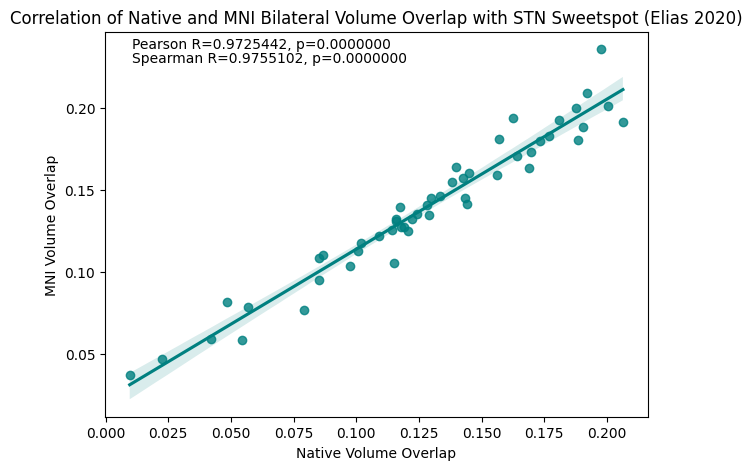

In [43]:
#correlation plots
def plot_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,path):
    plt.figure(figsize=(7, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Native Volume Overlap')
    plt.ylabel('MNI Volume Overlap')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.savefig(path)
    plt.show()

plot_analysis(df['Native_STN_Bi_Volume_Overlap'],df['MNI_STN_Bi_Volume_Overlap'],'Correlation of Native and MNI Bilateral Volume Overlap with STN',stn_pearson_r,stn_pearson_p,stn_spearman_r,stn_spearman_p,'midnightblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/OSS-DBS/Native and MNI Bilateral Volume Overlap with STN Correlation.png')
plot_analysis(df['Native_Motor_STN_Bi_Volume_Overlap'],df['MNI_Motor_STN_Bi_Volume_Overlap'],'Correlation of Native and MNI Bilateral Volume Overlap with Motor STN',motor_stn_pearson_r,motor_stn_pearson_p,motor_stn_spearman_r,motor_stn_spearman_p,'steelblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/OSS-DBS/Native and MNI Bilateral Volume Overlap with Motor STN Correlation.png')
plot_analysis(df['Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap'],df['MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap'],'Correlation of Native and MNI Bilateral Volume Overlap with STN Sweetspot (Elias 2020)',pd_pearson_r,pd_pearson_p,pd_spearman_r,pd_spearman_p,'teal','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/OSS-DBS/Native and MNI Bilateral Volume Overlap with STN Sweetspot (Elias 2020) Correlation.png')

# FieldTrip Plots

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_45662/675636082.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Column', y='Value', data=melted_df,palette='crest')


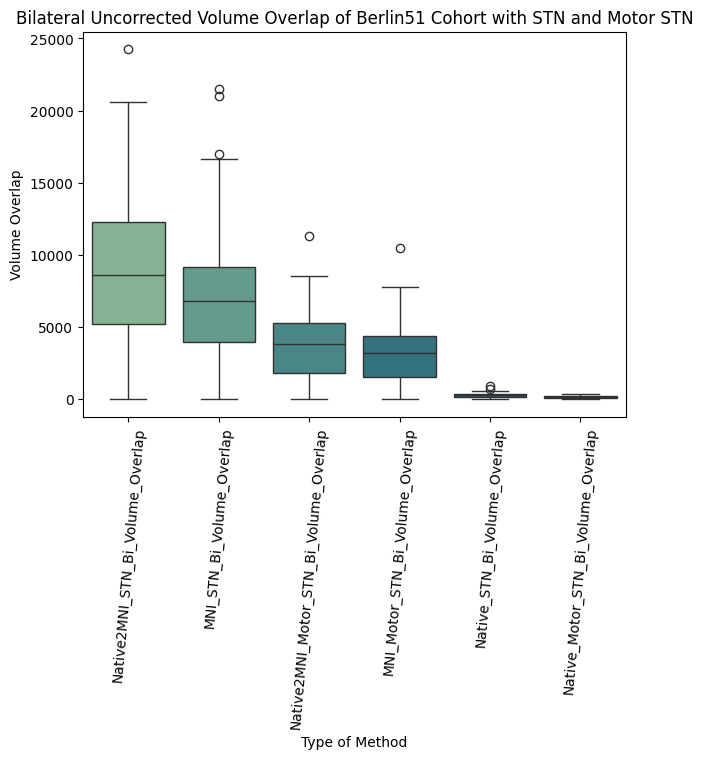

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_45662/675636082.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Column', y='Value', data=melted_df,palette='crest')


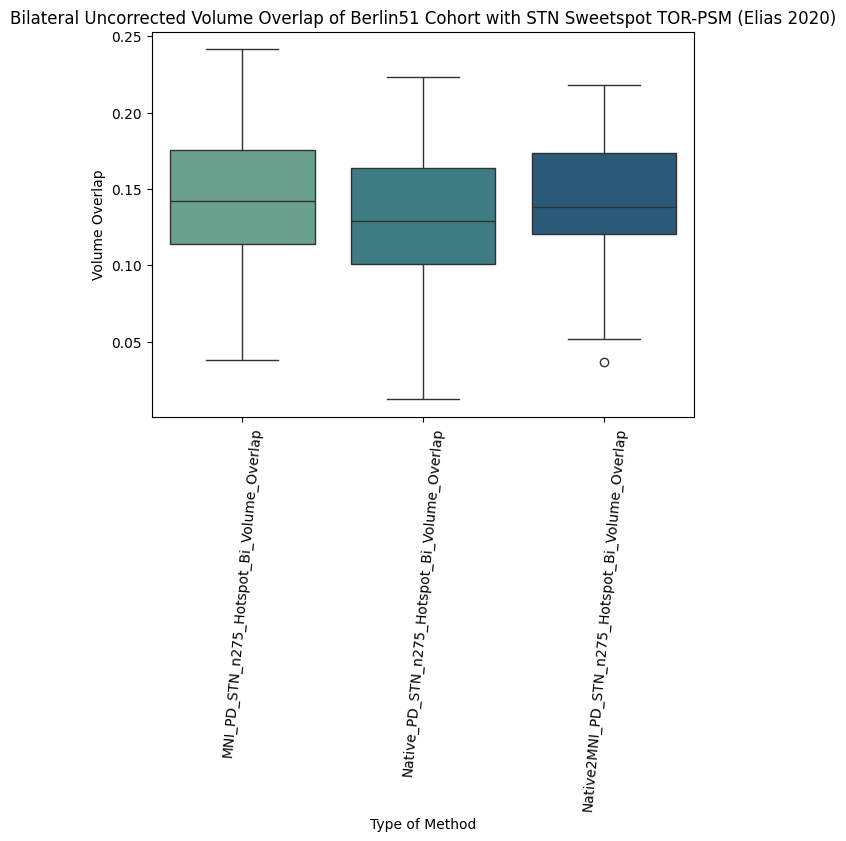

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_45662/675636082.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Column', y='Value', data=melted_df,palette='crest')


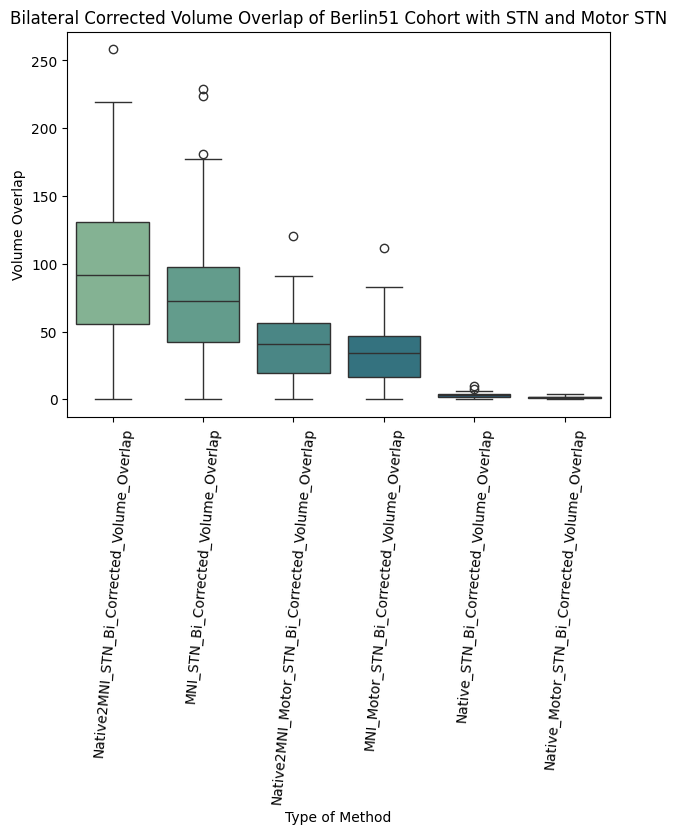

/var/folders/wf/8pxjw4251t7fl_l85_v1_33r0000gp/T/ipykernel_45662/675636082.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Column', y='Value', data=melted_df,palette='crest')


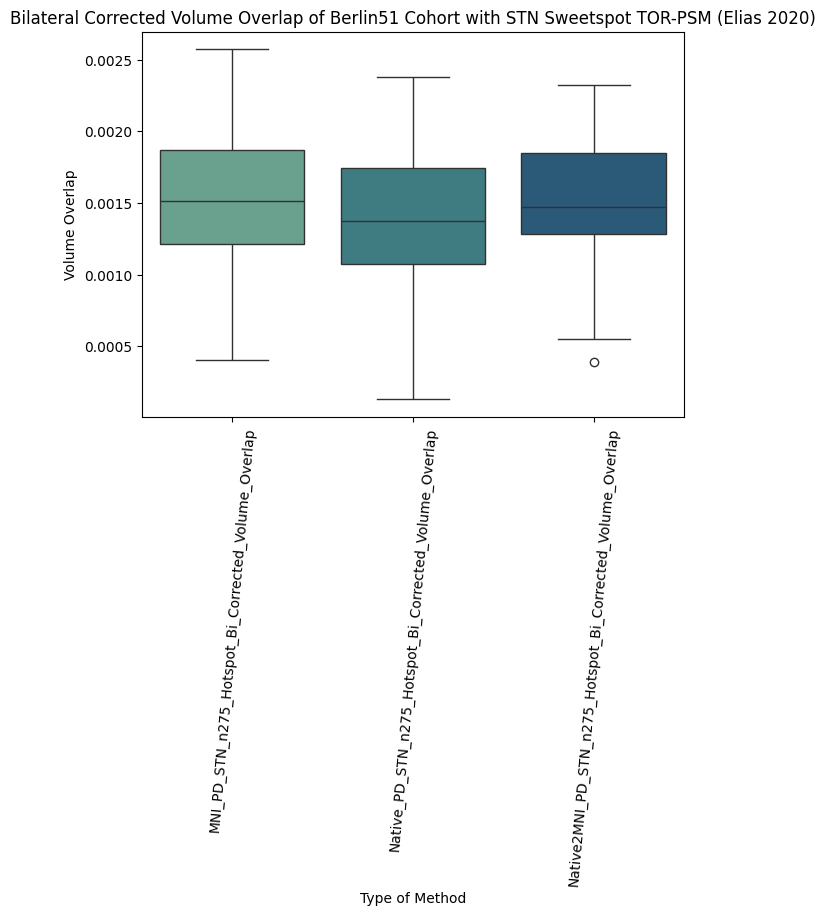

In [27]:
#plotting bilateral overlap with STNs, and Hotspots
def plot_overlap(columns_to_include,title):
    df = pd.read_csv('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip_Berlin51_Overlap.csv')
    selected_df = df[columns_to_include]
    melted_df = selected_df.melt(var_name='Column', value_name='Value')
    melted_df = melted_df.sort_values(by='Value', ascending=False)

    plt.figure(figsize=(7, 5))
    ax = sns.boxplot(x='Column', y='Value', data=melted_df,palette='crest')
    ax.set(xlabel = 'Type of Method',ylabel='Volume Overlap',title=title)
    ax.tick_params(axis='x', rotation=85)
    plt.show()
    
plot_overlap((['Native_STN_Bi_Volume_Overlap', 'Native2MNI_STN_Bi_Volume_Overlap','MNI_STN_Bi_Volume_Overlap','Native_Motor_STN_Bi_Volume_Overlap', 'Native2MNI_Motor_STN_Bi_Volume_Overlap','MNI_Motor_STN_Bi_Volume_Overlap']),'Bilateral Uncorrected Volume Overlap of Berlin51 Cohort with STN and Motor STN')
plot_overlap((['Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap','Native2MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap','MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap']),'Bilateral Uncorrected Volume Overlap of Berlin51 Cohort with STN Sweetspot TOR-PSM (Elias 2020)')
plot_overlap((['Native_STN_Bi_Corrected_Volume_Overlap', 'Native2MNI_STN_Bi_Corrected_Volume_Overlap','MNI_STN_Bi_Corrected_Volume_Overlap','Native_Motor_STN_Bi_Corrected_Volume_Overlap', 'Native2MNI_Motor_STN_Bi_Corrected_Volume_Overlap','MNI_Motor_STN_Bi_Corrected_Volume_Overlap']),'Bilateral Corrected Volume Overlap of Berlin51 Cohort with STN and Motor STN')
plot_overlap((['Native_PD_STN_n275_Hotspot_Bi_Corrected_Volume_Overlap','Native2MNI_PD_STN_n275_Hotspot_Bi_Corrected_Volume_Overlap','MNI_PD_STN_n275_Hotspot_Bi_Corrected_Volume_Overlap']),'Bilateral Corrected Volume Overlap of Berlin51 Cohort with STN Sweetspot TOR-PSM (Elias 2020)')

In [29]:
#get r and p values for overlaps
def r_p(vol_overlap_col):
    df = pd.read_csv('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip_Berlin51_Overlap.csv')
    pearson_r, pearson_p = pearsonr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    spearman_r, spearman_p = spearmanr(df['UPDRS_Improvement_Perc'],df[vol_overlap_col])
    return pearson_r, pearson_p, spearman_r, spearman_p

native_stn_pearson_r,native_stn_pearson_p,native_stn_spearman_r,native_stn_spearman_p = r_p('Native_STN_Bi_Volume_Overlap')
native2mni_stn_pearson_r,native2mni_stn_pearson_p,native2mni_stn_spearman_r,native2mni_stn_spearman_p = r_p('Native2MNI_STN_Bi_Volume_Overlap')
mni_stn_pearson_r,mni_stn_pearson_p,mni_stn_spearman_r,mni_stn_spearman_p = r_p('MNI_STN_Bi_Volume_Overlap')

native_motor_stn_pearson_r,native_motor_stn_pearson_p,native_motor_stn_spearman_r,native_motor_stn_spearman_p = r_p('Native_Motor_STN_Bi_Volume_Overlap')
native2mni_motor_stn_pearson_r,native2mni_motor_stn_pearson_p,native2mni_motor_stn_spearman_r,native2mni_motor_stn_spearman_p = r_p('Native2MNI_Motor_STN_Bi_Volume_Overlap')
mni_motor_stn_pearson_r,mni_motor_stn_pearson_p,mni_motor_stn_spearman_r,mni_motor_stn_spearman_p = r_p('MNI_Motor_STN_Bi_Volume_Overlap')

native_pd_pearson_r,native_pd_pearson_p,native_pd_spearman_r,native_pd_spearman_p = r_p('Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap')
native2mni_pd_pearson_r,native2mni_pd_pearson_p,native2mni_pd_spearman_r,native2mni_pd_spearman_p = r_p('Native2MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap')
mni_pd_pearson_r,mni_pd_pearson_p,mni_pd_spearman_r,mni_pd_spearman_p = r_p('MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap')

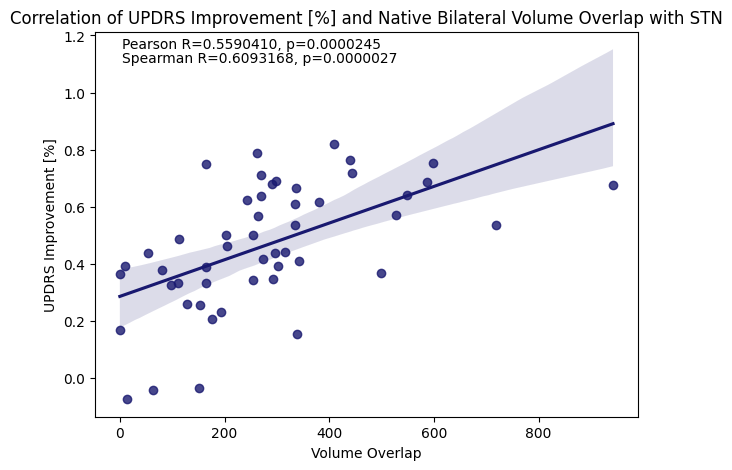

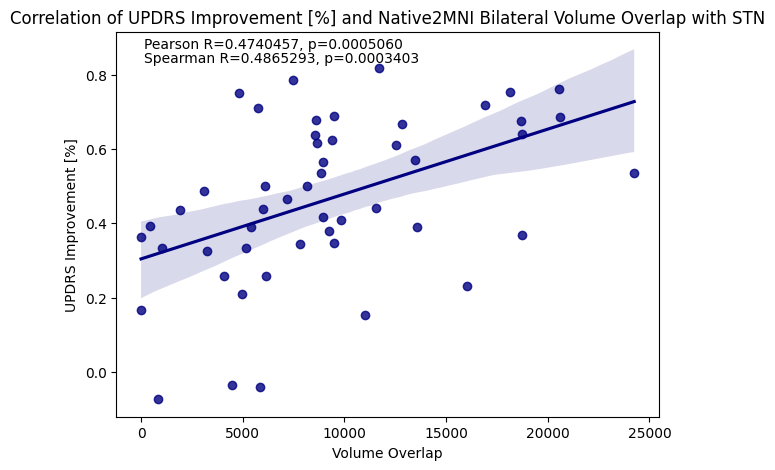

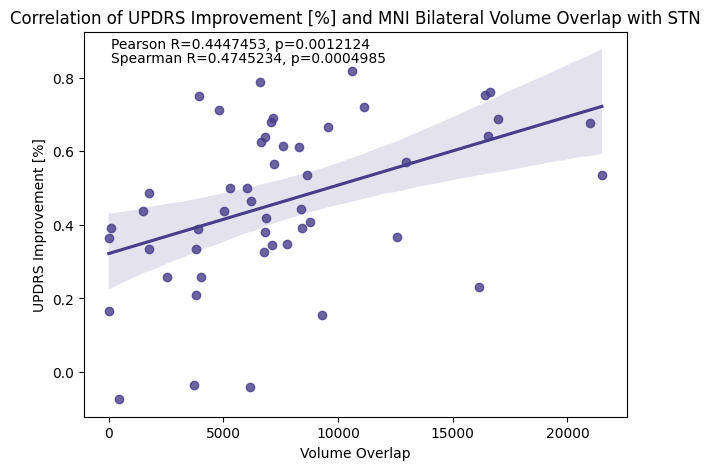

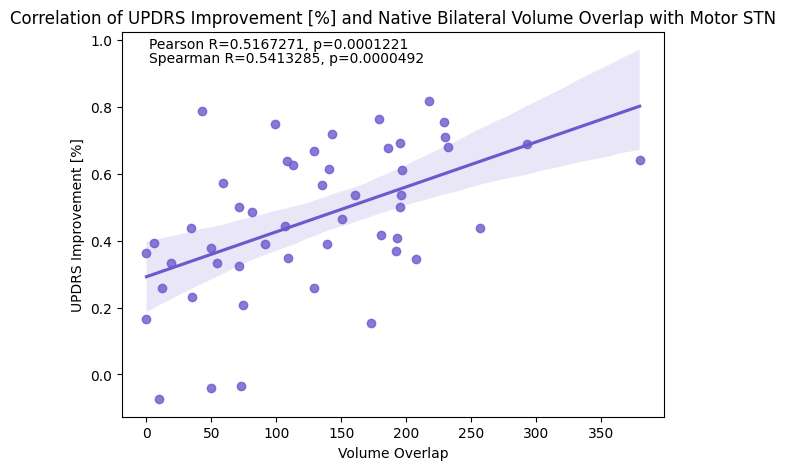

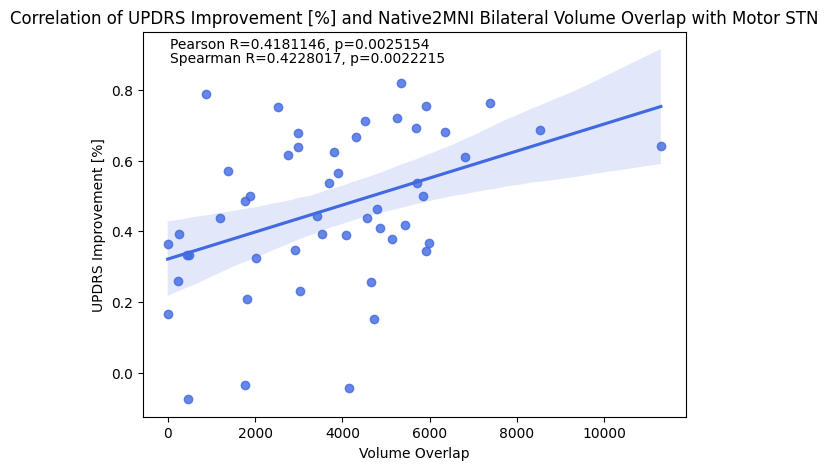

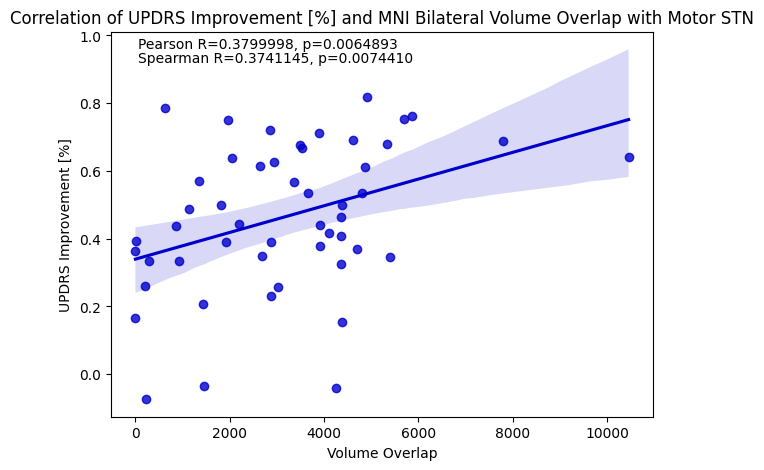

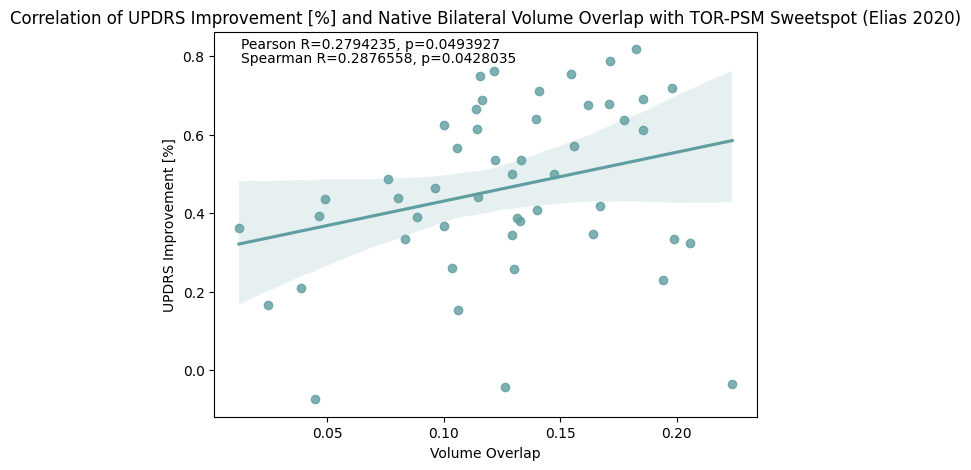

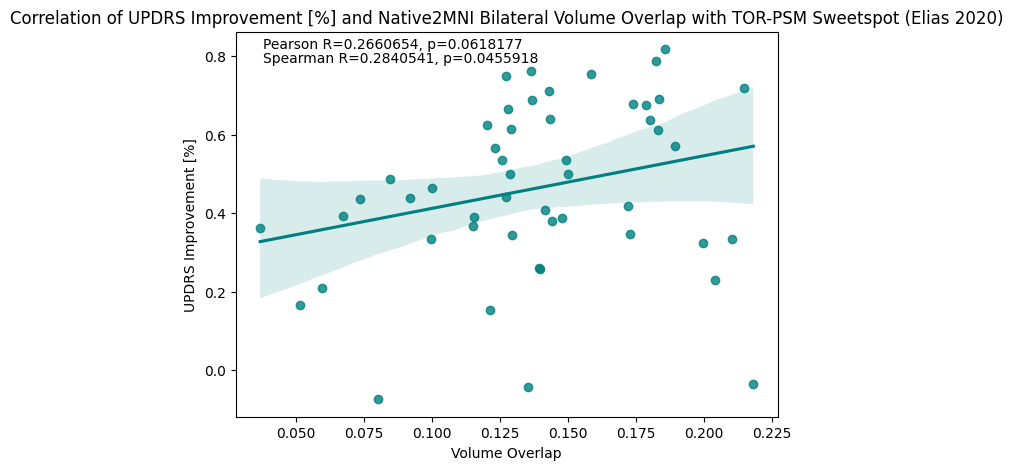

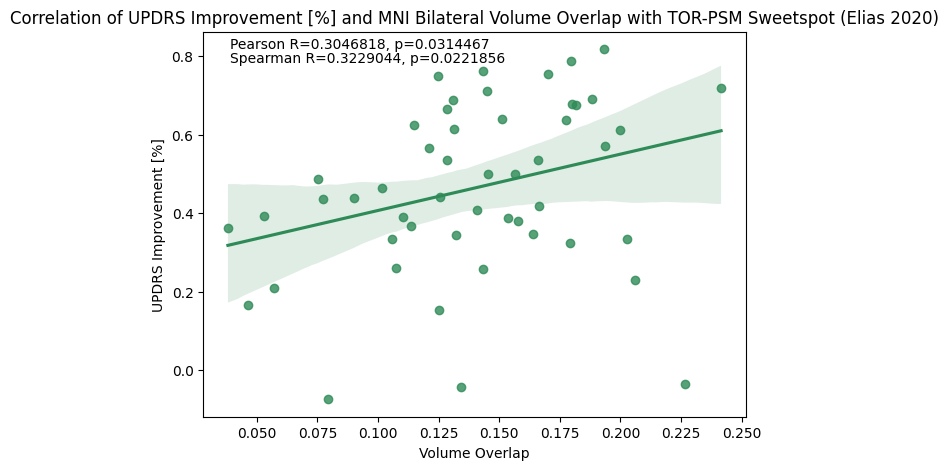

In [32]:
#correlation plots
def plot_analysis(x_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,path):
    plt.figure(figsize=(7, 5))
    ax = sns.regplot(x=x_data, y=df['UPDRS_Improvement_Perc'], color=color)
    plt.title(title)
    plt.xlabel('Volume Overlap')
    plt.ylabel('UPDRS Improvement [%]')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.savefig(path)
    plt.show()

df = pd.read_csv('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip_Berlin51_Overlap.csv')

plot_analysis(df['Native_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native Bilateral Volume Overlap with STN',native_stn_pearson_r,native_stn_pearson_p,native_stn_spearman_r,native_stn_spearman_p,'midnightblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native Bilateral Volume Overlap with STN.png')
plot_analysis(df['Native2MNI_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native2MNI Bilateral Volume Overlap with STN',native2mni_stn_pearson_r,native2mni_stn_pearson_p,native2mni_stn_spearman_r,native2mni_stn_spearman_p,'navy','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native2MNI Bilateral Volume Overlap with STN.png')
plot_analysis(df['MNI_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and MNI Bilateral Volume Overlap with STN',mni_stn_pearson_r,mni_stn_pearson_p,mni_stn_spearman_r,mni_stn_spearman_p,'darkslateblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/MNI Bilateral Volume Overlap with STN.png')

plot_analysis(df['Native_Motor_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native Bilateral Volume Overlap with Motor STN',native_motor_stn_pearson_r,native_motor_stn_pearson_p,native_motor_stn_spearman_r,native_motor_stn_spearman_p,'slateblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native Bilateral Volume Overlap with Motor STN.png')
plot_analysis(df['Native2MNI_Motor_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native2MNI Bilateral Volume Overlap with Motor STN',native2mni_motor_stn_pearson_r,native2mni_motor_stn_pearson_p,native2mni_motor_stn_spearman_r,native2mni_motor_stn_spearman_p,'royalblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native2MNI Bilateral Volume Overlap with Motor STN.png')
plot_analysis(df['MNI_Motor_STN_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and MNI Bilateral Volume Overlap with Motor STN',mni_motor_stn_pearson_r,mni_motor_stn_pearson_p,mni_motor_stn_spearman_r,mni_motor_stn_spearman_p,'mediumblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/MNI Bilateral Volume Overlap with Motor STN.png')

plot_analysis(df['Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020)',native_pd_pearson_r,native_pd_pearson_p,native_pd_spearman_r,native_pd_spearman_p,'cadetblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020).png')
plot_analysis(df['Native2MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and Native2MNI Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020)',native2mni_pd_pearson_r,native2mni_pd_pearson_p,native2mni_pd_spearman_r,native2mni_pd_spearman_p,'teal','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native2MNI Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020).png')
plot_analysis(df['MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap'],'Correlation of UPDRS Improvement [%] and MNI Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020)',mni_pd_pearson_r,mni_pd_pearson_p,mni_pd_spearman_r,mni_pd_spearman_p,'seagreen','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/MNI Bilateral Volume Overlap with TOR-PSM Sweetspot (Elias 2020).png')

In [3]:
#correlation of different method overlaps (native vs mni)
#get r and p values
def r_p(native,mni):
    df = pd.read_csv('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip_Berlin51_Overlap.csv')
    pearson_r, pearson_p = pearsonr(df[native],df[mni])
    spearman_r, spearman_p = spearmanr(df[native],df[mni])
    return pearson_r, pearson_p, spearman_r, spearman_p

stn_pearson_r,stn_pearson_p,stn_spearman_r,stn_spearman_p = r_p('Native_STN_Bi_Volume_Overlap','MNI_STN_Bi_Volume_Overlap')
motor_stn_pearson_r,motor_stn_pearson_p,motor_stn_spearman_r,motor_stn_spearman_p = r_p('Native_Motor_STN_Bi_Volume_Overlap','MNI_Motor_STN_Bi_Volume_Overlap')
pd_pearson_r,pd_pearson_p,pd_spearman_r,pd_spearman_p = r_p('Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap','MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap')

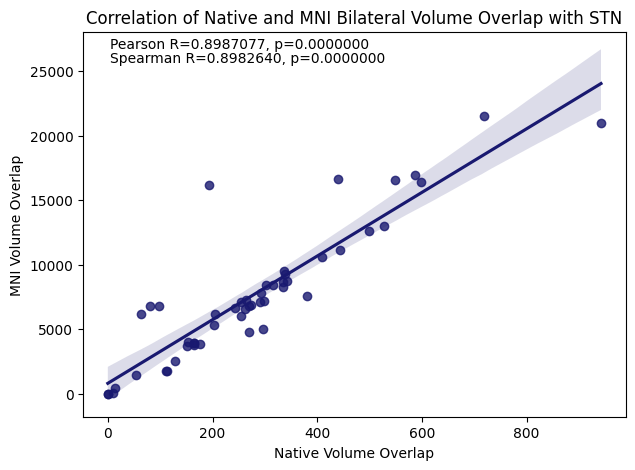

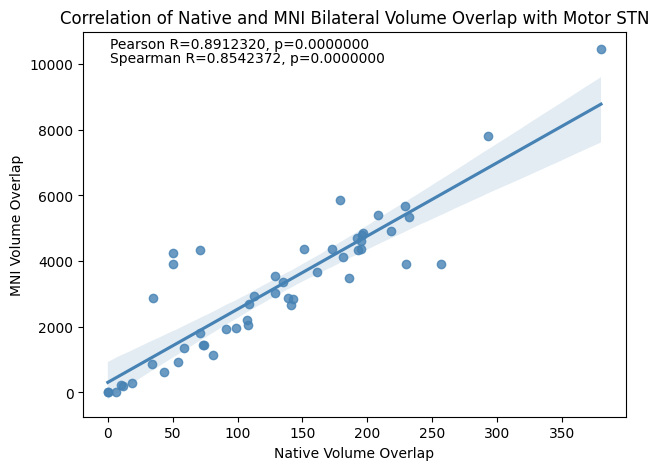

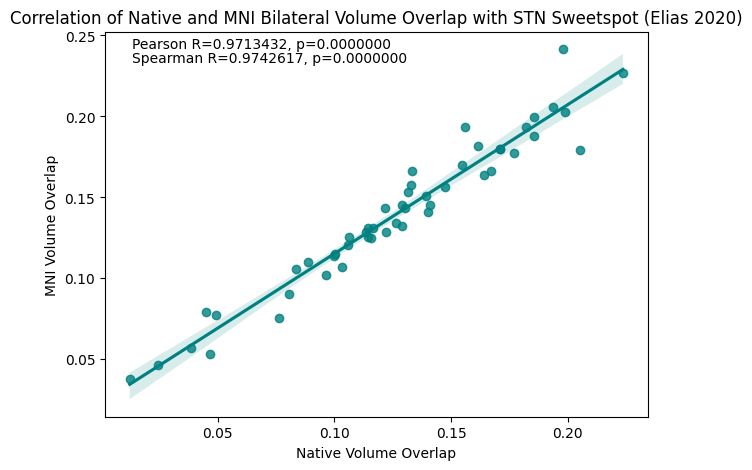

In [4]:
#correlation plots
def plot_analysis(x_data, y_data, title, pearson_r_val, pearson_p_val, spearman_r_val, spearman_p_val, color,path):
    plt.figure(figsize=(7, 5))
    ax = sns.regplot(x=x_data, y=y_data, color=color)
    plt.title(title)
    plt.xlabel('Native Volume Overlap')
    plt.ylabel('MNI Volume Overlap')
    ax.text(0.05, 0.95, 'Pearson R={:.7f}, p={:.7f}'.format(pearson_r_val, pearson_p_val),
            transform=ax.transAxes, verticalalignment='bottom')
    ax.text(0.05, 0.95, 'Spearman R={:.7f}, p={:.7f}'.format(spearman_r_val, spearman_p_val),
            transform=ax.transAxes, verticalalignment='top')
    plt.savefig(path)
    plt.show()

df = pd.read_csv('/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/FieldTrip_Berlin51_Overlap.csv')

plot_analysis(df['Native_STN_Bi_Volume_Overlap'],df['MNI_STN_Bi_Volume_Overlap'],'Correlation of Native and MNI Bilateral Volume Overlap with STN',stn_pearson_r,stn_pearson_p,stn_spearman_r,stn_spearman_p,'midnightblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native and MNI Bilateral Volume Overlap with STN Correlation.png')
plot_analysis(df['Native_Motor_STN_Bi_Volume_Overlap'],df['MNI_Motor_STN_Bi_Volume_Overlap'],'Correlation of Native and MNI Bilateral Volume Overlap with Motor STN',motor_stn_pearson_r,motor_stn_pearson_p,motor_stn_spearman_r,motor_stn_spearman_p,'steelblue','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native and MNI Bilateral Volume Overlap with Motor STN Correlation.png')
plot_analysis(df['Native_PD_STN_n275_Hotspot_Bi_Volume_Overlap'],df['MNI_PD_STN_n275_Hotspot_Bi_Volume_Overlap'],'Correlation of Native and MNI Bilateral Volume Overlap with STN Sweetspot (Elias 2020)',pd_pearson_r,pd_pearson_p,pd_spearman_r,pd_spearman_p,'teal','/Volumes/Cingulate/Native&MNI_Overlaps/Berlin51/Figures/FieldTrip/Native and MNI Bilateral Volume Overlap with STN Sweetspot (Elias 2020) Correlation.png')

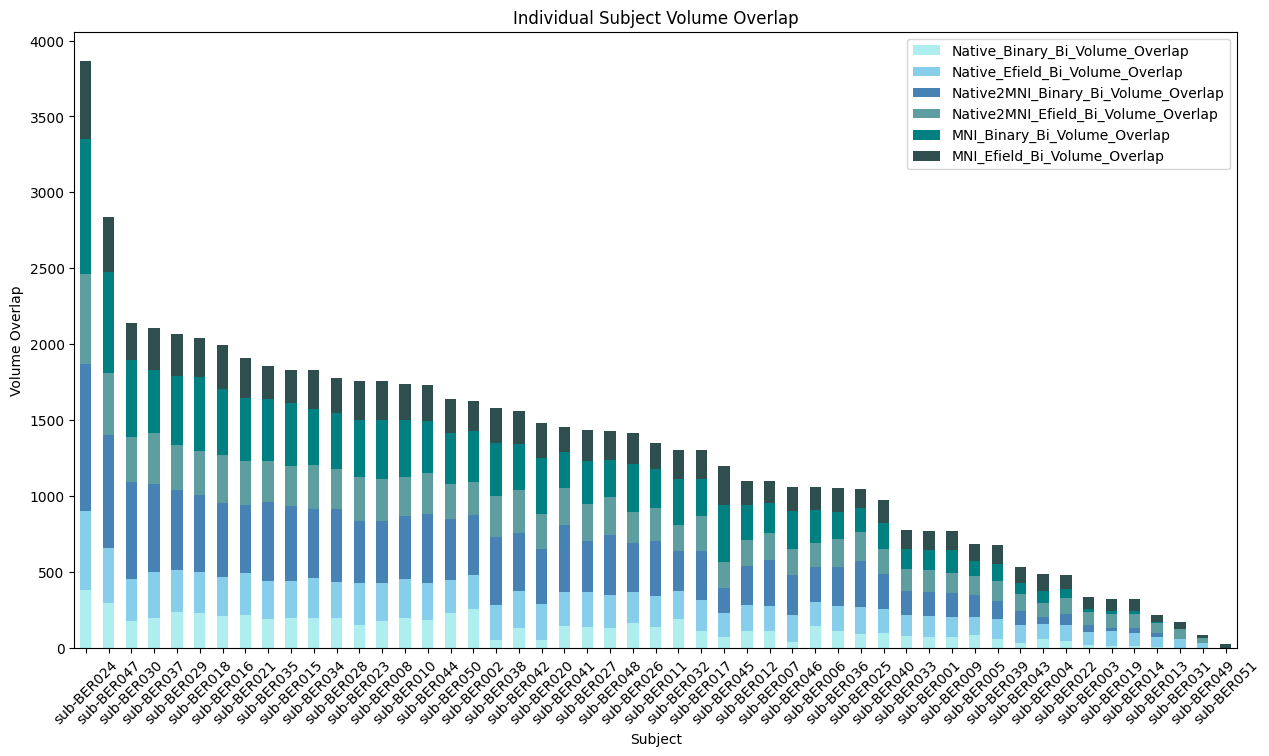

In [48]:
#old
columns_to_exclude = ['UPDRS_Improvement_Perc','Native_Binary_LH_Volume_Overlap','Native_Binary_RH_Volume_Overlap','Native_Efield_LH_Volume_Overlap','Native_Efield_RH_Volume_Overlap','Native2MNI_Binary_LH_Volume_Overlap','Native2MNI_Binary_RH_Volume_Overlap','Native2MNI_Efield_LH_Volume_Overlap','Native2MNI_Efield_RH_Volume_Overlap','MNI_Binary_LH_Volume_Overlap','MNI_Binary_RH_Volume_Overlap','MNI_Efield_LH_Volume_Overlap','MNI_Efield_RH_Volume_Overlap']
selected_df = df.drop(columns=columns_to_exclude)
sorted_df = selected_df.loc[selected_df.sum(axis=1).sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(15, 8))

sorted_df.plot(kind='bar', stacked=True, color=['paleturquoise', 'skyblue', 'steelblue', 'cadetblue', 'teal', 'darkslategrey'], ax=ax)

plt.xticks(rotation=45)

plt.title('Individual Subject Volume Overlap')
plt.xlabel('Subject')
plt.ylabel('Volume Overlap')

plt.show()